<a href="https://colab.research.google.com/github/AeAre/Fruit_classification_using_CNN/blob/main/Fruit_Classification_using_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

from PIL import Image

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model

from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.callbacks import EarlyStopping

!pip install ipywidgets -q
import ipywidgets as widgets
from IPython.display import display

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 64.8 MB/s eta 0:00:00


In [ ]:
pip install --upgrade pip

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 46.4 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2


In [ ]:
!pip install opendatasets -q
import opendatasets as od
od.download("https://www.kaggle.com/datasets/sshikamaru/fruit-recognition/data")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: 1
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/sshikamaru/fruit-recognition


100%|██████████| 102M/102M [00:00<00:00, 1.24GB/s]

In [ ]:
import os

base_path = "/content/fruit-recognition"

train_path = os.path.join(base_path, 'train/train')
test_path = os.path.join(base_path, 'test/test')

In [ ]:
train_path

'/content/fruit-recognition/train/train'

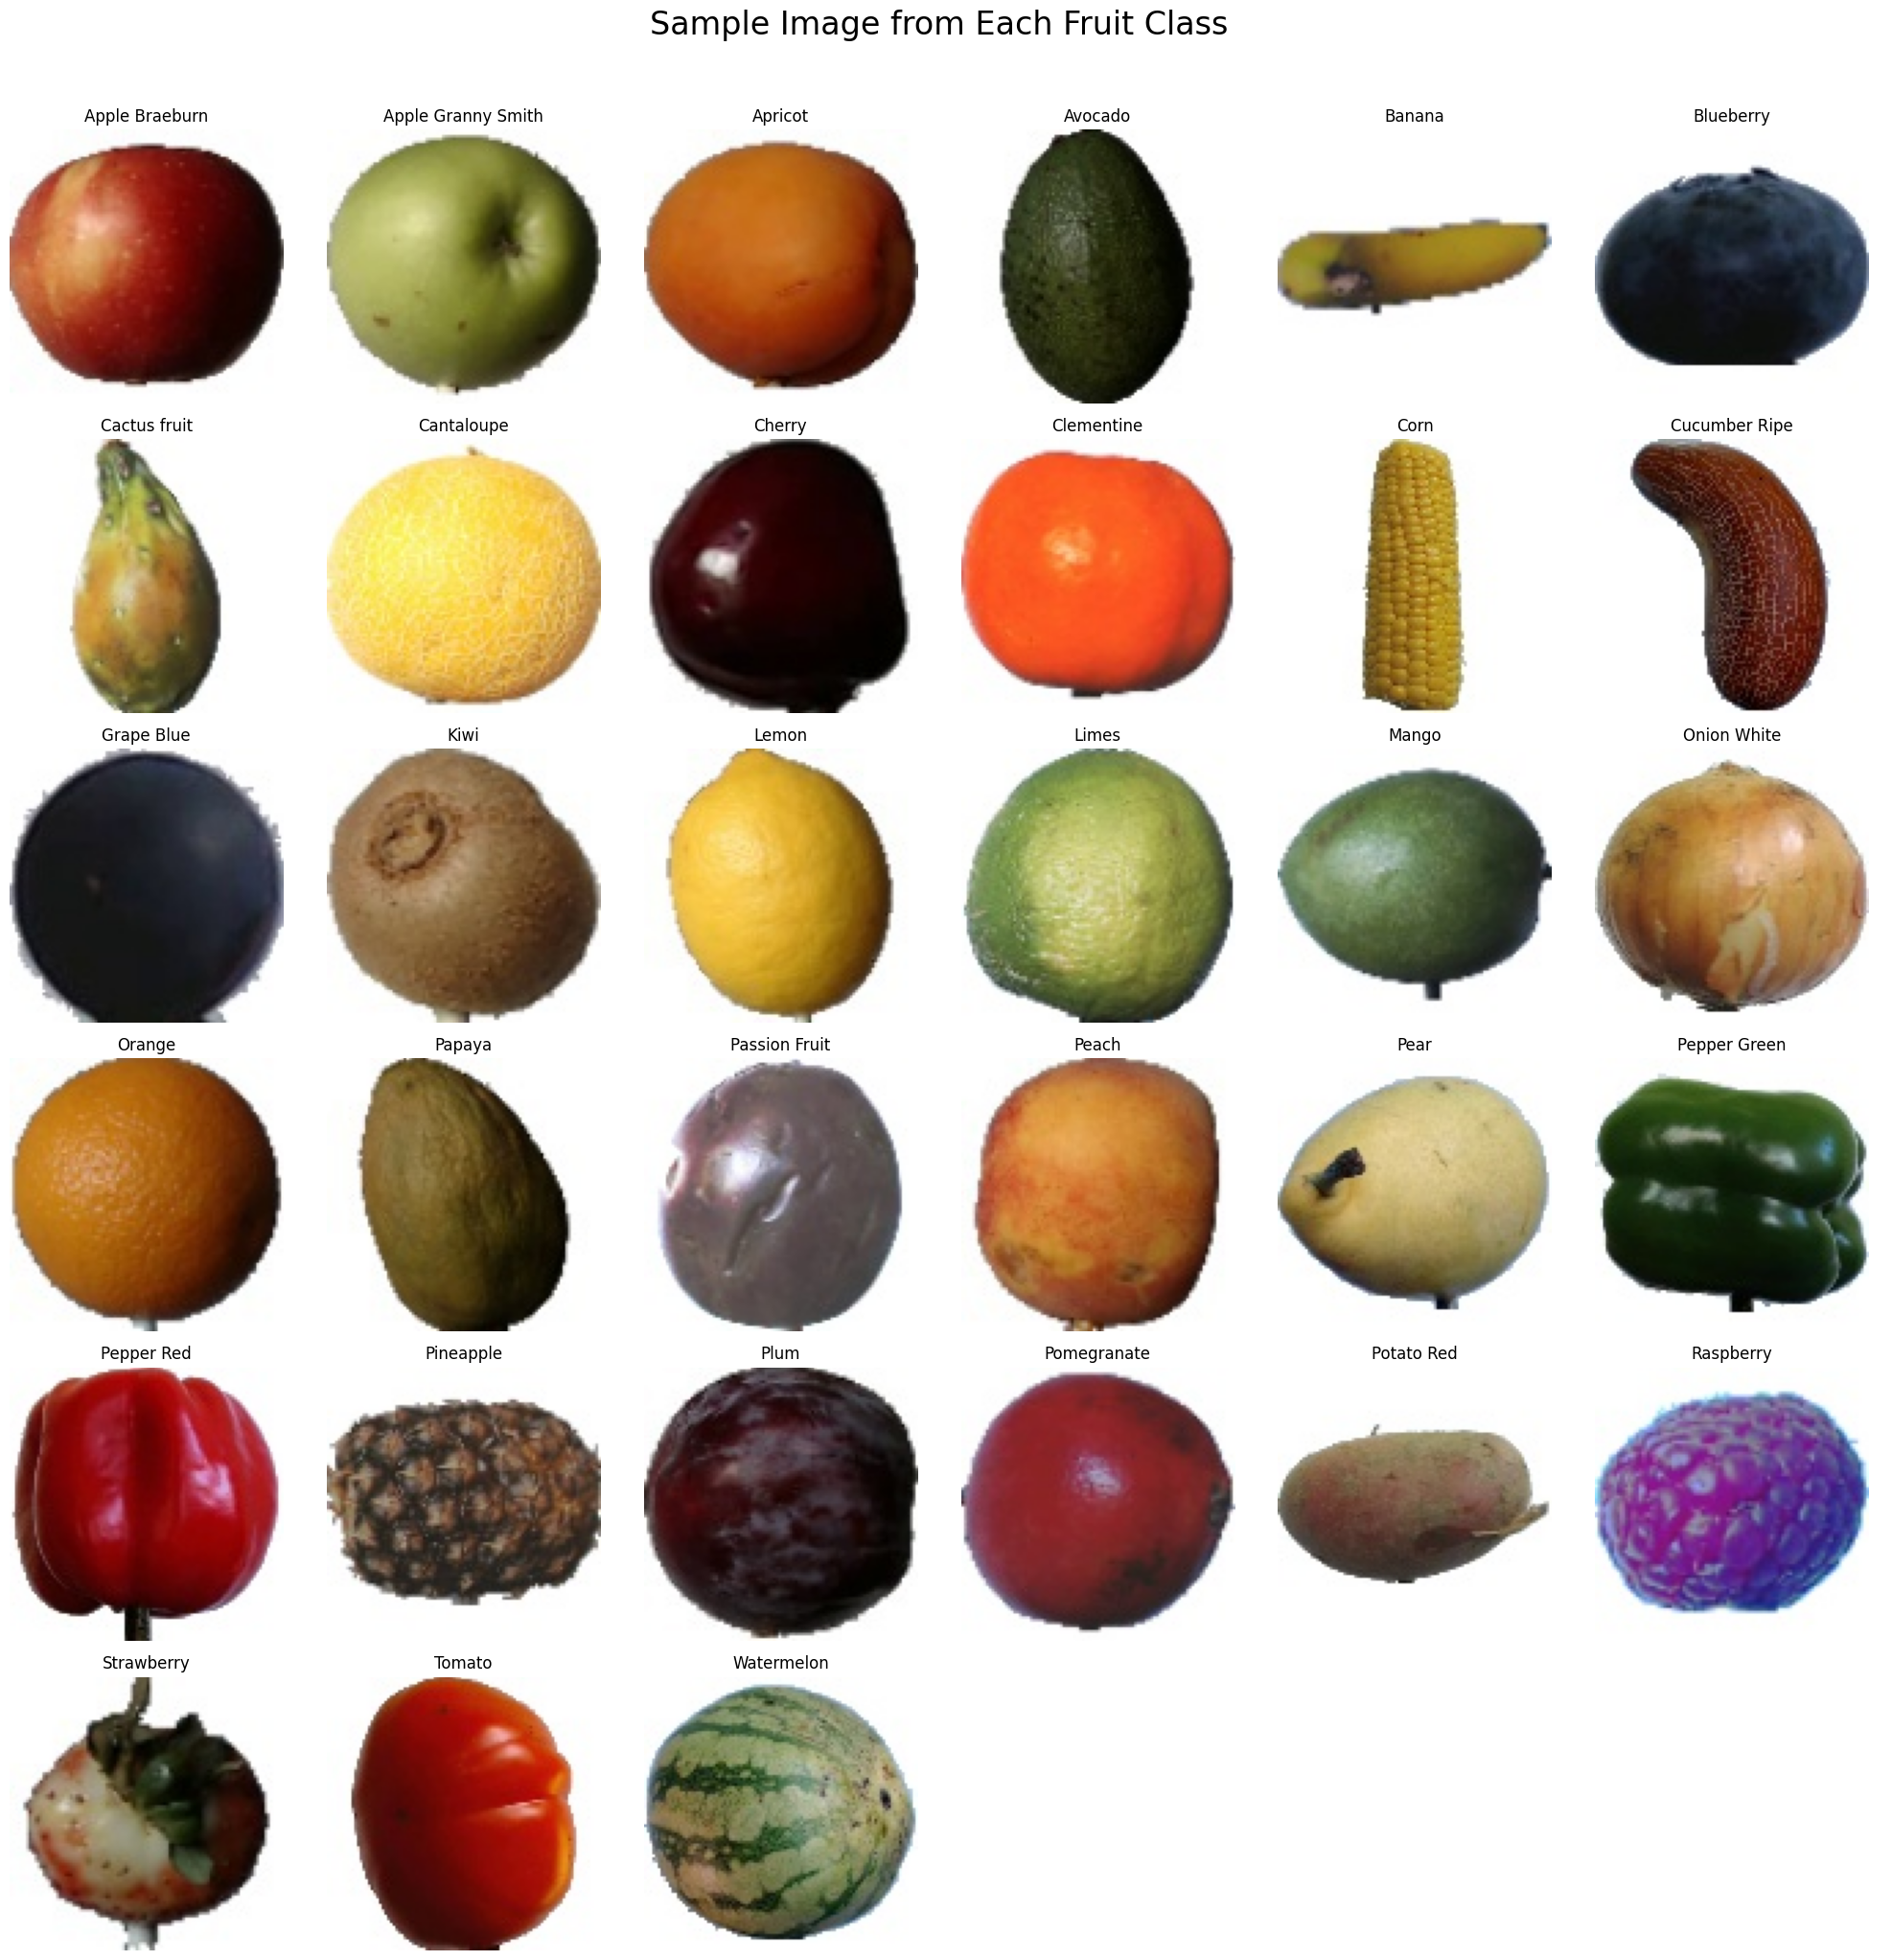

In [ ]:
import random

class_names = sorted(os.listdir(train_path))

fig, axes= plt.subplots(6, 6, figsize=(20,20))
fig.suptitle("Sample Image from Each Fruit Class", fontsize=24, y=1.02)
axes = axes.ravel()

for i, class_name in enumerate(class_names):
  class_dir = os.path.join(train_path, class_name)
  image_files = os.listdir(class_dir)

  if image_files:
    image_path = os.path.join(class_dir, random.choice(image_files))
    img = mpimg.imread(image_path)
    axes[i].imshow(img)
    axes[i].set_title(class_name, fontsize=12)
    axes[i].axis("off")

for j in range(len(class_names), len(axes)):
  axes[j].axis("off")

plt.tight_layout()
plt.show()

In [ ]:
class_names = sorted(os.listdir(train_path))

print("Classes:", class_names)
print("Total number of classes:", len(class_names))

Classes: ['Apple Braeburn', 'Apple Granny Smith', 'Apricot', 'Avocado', 'Banana', 'Blueberry', 'Cactus fruit', 'Cantaloupe', 'Cherry', 'Clementine', 'Corn', 'Cucumber Ripe', 'Grape Blue', 'Kiwi', 'Lemon', 'Limes', 'Mango', 'Onion White', 'Orange', 'Papaya', 'Passion Fruit', 'Peach', 'Pear', 'Pepper Green', 'Pepper Red', 'Pineapple', 'Plum', 'Pomegranate', 'Potato Red', 'Raspberry', 'Strawberry', 'Tomato', 'Watermelon']
Total number of classes: 33


In [ ]:
for name in class_names:
  class_path = os.path.join(train_path, name)
  num_images = len(os.listdir(class_path))
  print(f"Class: {name}, Number of Images: {num_images}")

Class: Apple Braeburn, Number of Images: 492
Class: Apple Granny Smith, Number of Images: 492
Class: Apricot, Number of Images: 492
Class: Avocado, Number of Images: 427
Class: Banana, Number of Images: 490
Class: Blueberry, Number of Images: 462
Class: Cactus fruit, Number of Images: 490
Class: Cantaloupe, Number of Images: 492
Class: Cherry, Number of Images: 492
Class: Clementine, Number of Images: 490
Class: Corn, Number of Images: 450
Class: Cucumber Ripe, Number of Images: 392
Class: Grape Blue, Number of Images: 984
Class: Kiwi, Number of Images: 466
Class: Lemon, Number of Images: 492
Class: Limes, Number of Images: 490
Class: Mango, Number of Images: 490
Class: Onion White, Number of Images: 438
Class: Orange, Number of Images: 479
Class: Papaya, Number of Images: 492
Class: Passion Fruit, Number of Images: 490
Class: Peach, Number of Images: 492
Class: Pear, Number of Images: 696
Class: Pepper Green, Number of Images: 444
Class: Pepper Red, Number of Images: 666
Class: Pineap

In [ ]:
class_counts = {
    cls: len(os.listdir(os.path.join(train_path, cls)))
    for cls in class_names
}

df_counts = pd.DataFrame(class_counts.items(), columns=['Class', 'Count'])
df_counts = df_counts.sort_values(by="Count", ascending=False)
df_counts.insert(0, "sl.no", range(1, len(df_counts) + 1))

df_counts.style.hide(axis="index")

/tmp/ipython-input-4010722033.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Class", y="Count", data=df_counts, palette="viridis")


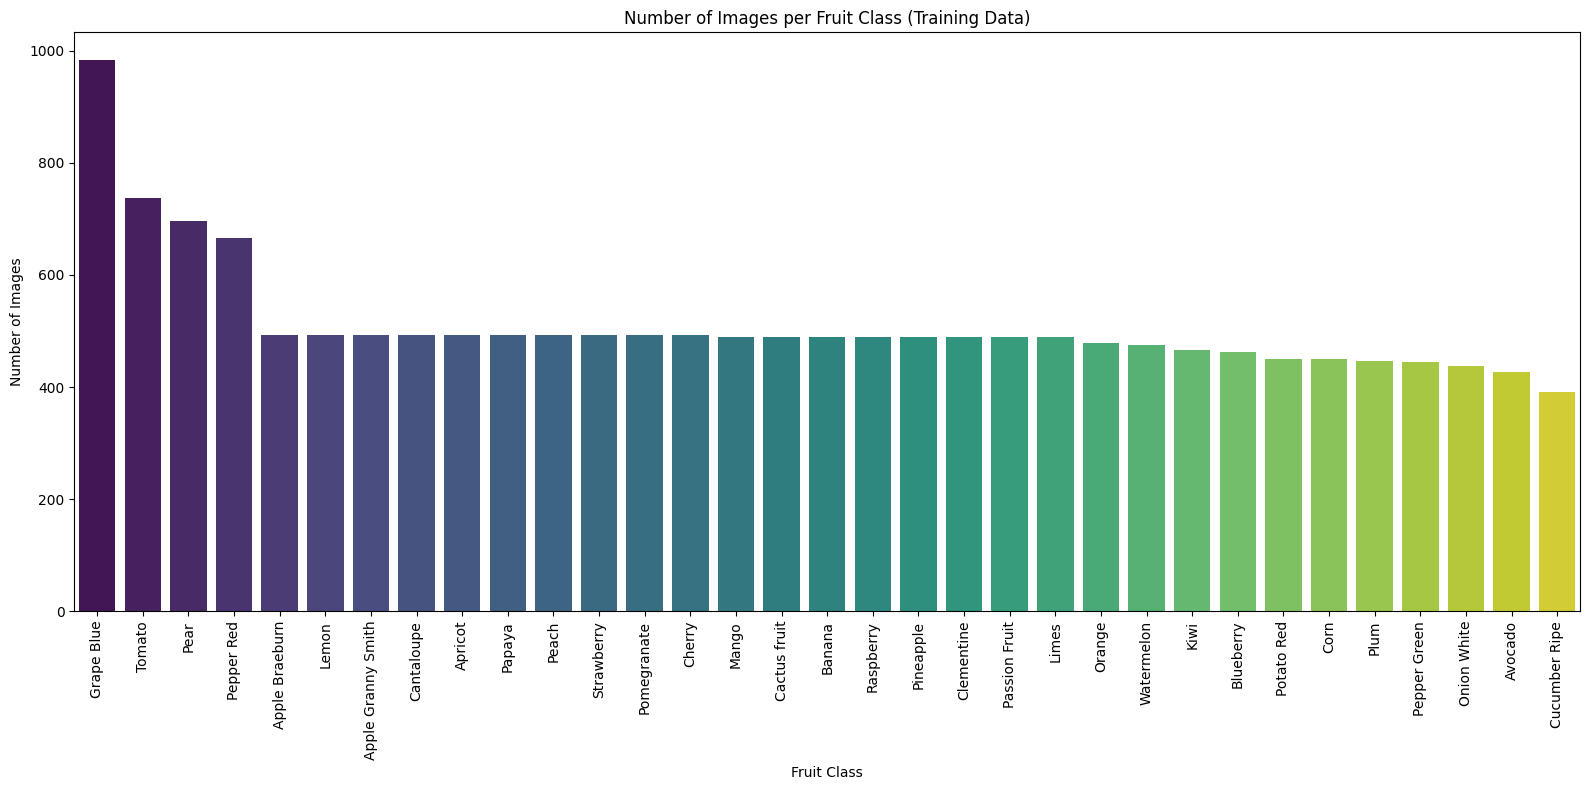

In [ ]:
plt.figure(figsize=(16, 8))
sns.barplot(x="Class", y="Count", data=df_counts, palette="viridis")
plt.title("Number of Images per Fruit Class (Training Data)")
plt.xlabel("Fruit Class")
plt.ylabel("Number of Images")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

### Data Processing and splitting

In [ ]:
img_width, img_height = 100, 100
batch_size = 32

datagen =ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_generator = datagen.flow_from_directory(
    train_path,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode="categorical",
    subset="training"
)

validation_generator = datagen.flow_from_directory(
    train_path,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode="categorical",
    subset="validation"
)

print(f"Training images: {train_generator.n}")
print(f"Validation images: {validation_generator.n}")
print(f"Number of classes: {train_generator.num_classes}")

Found 13493 images belonging to 33 classes.
Found 3361 images belonging to 33 classes.
Training images: 13493
Validation images: 3361
Number of classes: 33


### Data Augmentation

In [ ]:
img_width, img_height = 100, 100
batch_size = 32

datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode="nearest",
    validation_split=0.2
)

train_generator = datagen.flow_from_directory(
    train_path,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode="categorical",
    subset="training",
    shuffle=True
)

validation_generator = datagen.flow_from_directory(
    train_path,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode="categorical",
    subset="validation",
    shuffle=True
)

print(f"Training images: {train_generator.n}")
print(f"Validation images: {validation_generator.n}")
print(f"Number of classes: {train_generator.num_classes}")

Found 13493 images belonging to 33 classes.
Found 3361 images belonging to 33 classes.
Training images: 13493
Validation images: 3361
Number of classes: 33


### Model Evaluation

In [ ]:
num_classes = train_generator.num_classes
img_width, img_height = 100, 100

strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
  model = Sequential([
      tf.keras.layers.Conv2D(32, (3,3), activation="relu", input_shape=(img_width, img_height, 3)),
      tf.keras.layers.MaxPooling2D((2,2)),
      tf.keras.layers.Conv2D(64, (3, 3), activation="relu"),
      tf.keras.layers.MaxPooling2D((2, 2)),
      tf.keras.layers.Conv2D(128, (3, 3), activation="relu"),
      tf.keras.layers.MaxPooling2D((2, 2)),
      tf.keras.layers.Conv2D(128, (3, 3), activation="relu"),
      tf.keras.layers.MaxPooling2D((2, 2)),

      tf.keras.layers.Flatten(),
      tf.keras.layers.Dropout(0.5),
      tf.keras.layers.Dense(512, activation="relu"),
      tf.keras.layers.Dense(num_classes, activation="softmax")
  ])

  model.compile(
      optimizer="adam",
      loss="categorical_crossentropy",
      metrics=["accuracy"]
  )

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 98, 98, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 49, 49, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 47, 47, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 21, 21, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 33)             │        16,929 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,306,849 (4.99 MB)

 Trainable params: 1,306,849 (4.99 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
epochs = 20

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

history = model.fit(train_generator,
                    steps_per_epoch=train_generator.samples // train_generator.batch_size,
                    epochs=epochs,
                    validation_data=validation_generator,
                    validation_steps=validation_generator.samples // validation_generator.num_batches,
                    callbacks=[early_stop])

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
421/421 ━━━━━━━━━━━━━━━━━━━━ 59s 129ms/step - accuracy: 0.3962 - loss: 1.9491 - val_accuracy: 0.7863 - val_loss: 0.5421
Epoch 2/20
  1/421 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - accuracy: 0.8438 - loss: 0.4760

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


421/421 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.8438 - loss: 0.4760 - val_accuracy: 0.8075 - val_loss: 0.4981
Epoch 3/20
421/421 ━━━━━━━━━━━━━━━━━━━━ 72s 170ms/step - accuracy: 0.8461 - loss: 0.4189 - val_accuracy: 0.9143 - val_loss: 0.2385
Epoch 4/20
421/421 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.9375 - loss: 0.1963 - val_accuracy: 0.9224 - val_loss: 0.2401
Epoch 5/20
421/421 ━━━━━━━━━━━━━━━━━━━━ 69s 164ms/step - accuracy: 0.9139 - loss: 0.2511 - val_accuracy: 0.9274 - val_loss: 0.1990
Epoch 6/20
421/421 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.9062 - loss: 0.2744 - val_accuracy: 0.9466 - val_loss: 0.1487
Epoch 7/20
421/421 ━━━━━━━━━━━━━━━━━━━━ 80s 173ms/step - accuracy: 0.9339 - loss: 0.1961 - val_accuracy: 0.9637 - val_loss: 0.0890
Epoch 8/20
421/421 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9688 - loss: 0.0823 - val_accuracy: 0.9698 - val_loss: 0.0941
Epoch 9/20
421/421 ━━━━━━━━━━━━━━━━━━━━ 54s 128ms/step - accuracy: 0.9476 - loss: 0.1527 - val_accuracy

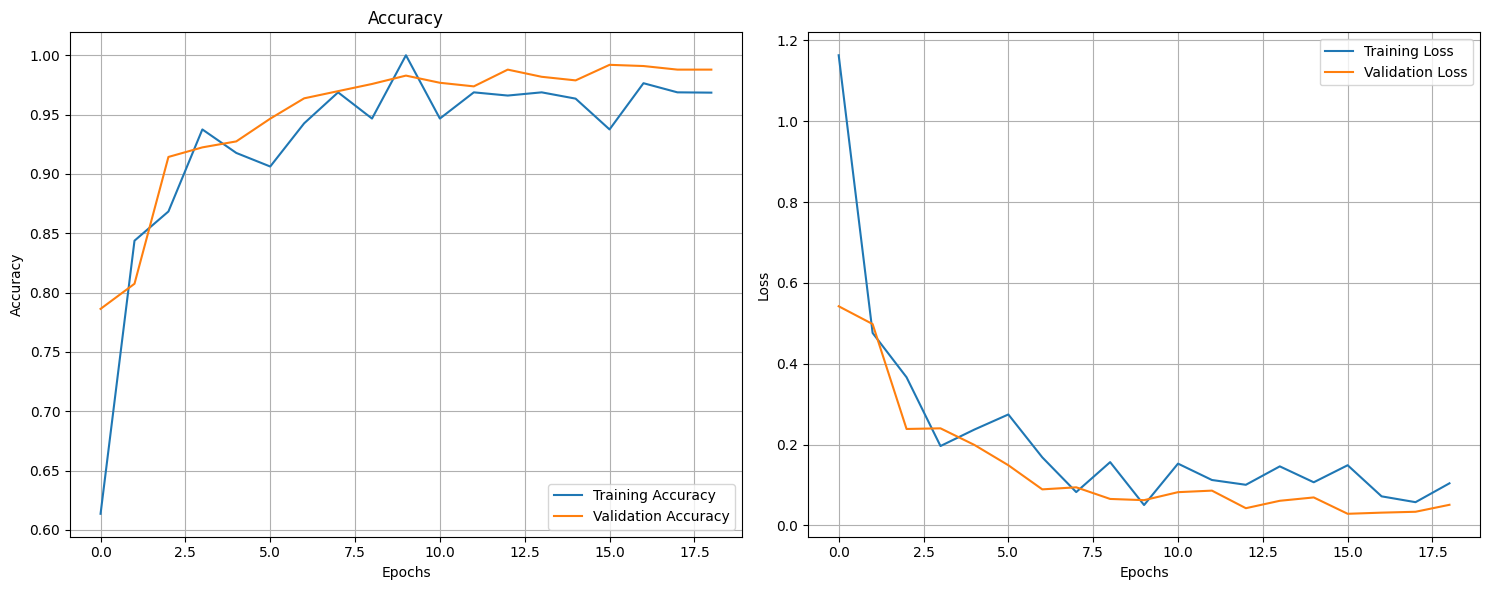

In [ ]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs_range = range(len(acc))

plt.figure(figsize=(15,6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label="Training Accuracy")
plt.plot(epochs_range, val_acc, label="Validation Accuracy")
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")
plt.grid(True)

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label="Training Loss")
plt.plot(epochs_range, val_loss, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc="upper right")
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
history.history["accuracy"]

[0.6136245727539062,
 0.84375,
 0.8683604598045349,
 0.9375,
 0.9176881313323975,
 0.90625,
 0.9426491260528564,
 0.96875,
 0.9466606974601746,
 1.0,
 0.9466606974601746,
 0.96875,
 0.9660500884056091,
 0.96875,
 0.9634499549865723,
 0.9375,
 0.976450502872467,
 0.96875,
 0.9685015678405762]

In [ ]:
final_accuracy = history.history["val_accuracy"][-1]
final_loss = history.history["val_loss"][-1]

print(f"Final Accuracy: {final_accuracy:.4f}")
print(f"Final Loss: {final_loss:.4f}")

Final Accuracy: 0.9879
Final Loss: 0.0508


In [ ]:
datagen_eval = ImageDataGenerator(rescale=1./255, validation_split=0.2)

validation_generator_eval = datagen_eval.flow_from_directory(
    train_path,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode="categorical",
    subset="validation", # Using validation subset as defined earlier
    shuffle=False # Crucial for correct evaluation
)

validation_labels_eval = validation_generator_eval.classes
validation_steps_eval = validation_generator_eval.samples // validation_generator_eval.batch_size

predictions = model.predict(validation_generator_eval, steps=validation_steps_eval)
predicted_labels = np.argmax(predictions, axis=1)

class_labels = list(validation_generator_eval.class_indices.keys())

# Ensure the lengths match for accurate reporting
report = classification_report(validation_labels_eval[:len(predicted_labels)], predicted_labels, target_names=class_labels)
print("\nClassification Report:\n", report)

Found 3361 images belonging to 33 classes.
  1/105 ━━━━━━━━━━━━━━━━━━━━ 11s 112ms/step

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step

Classification Report:
                     precision    recall  f1-score   support

    Apple Braeburn       1.00      1.00      1.00        98
Apple Granny Smith       1.00      1.00      1.00        98
           Apricot       1.00      0.98      0.99        98
           Avocado       1.00      1.00      1.00        85
            Banana       1.00      1.00      1.00        98
         Blueberry       1.00      1.00      1.00        92
      Cactus fruit       1.00      1.00      1.00        98
        Cantaloupe       0.99      1.00      0.99        98
            Cherry       1.00      0.96      0.98        98
        Clementine       1.00      1.00      1.00        98
              Corn       1.00      1.00      1.00        90
     Cucumber Ripe       1.00      1.00      1.00        78
        Grape Blue       1.00      1.00      1.00       196
              Kiwi       1.00      1.00      1.00        93
             Lemon       1.00   

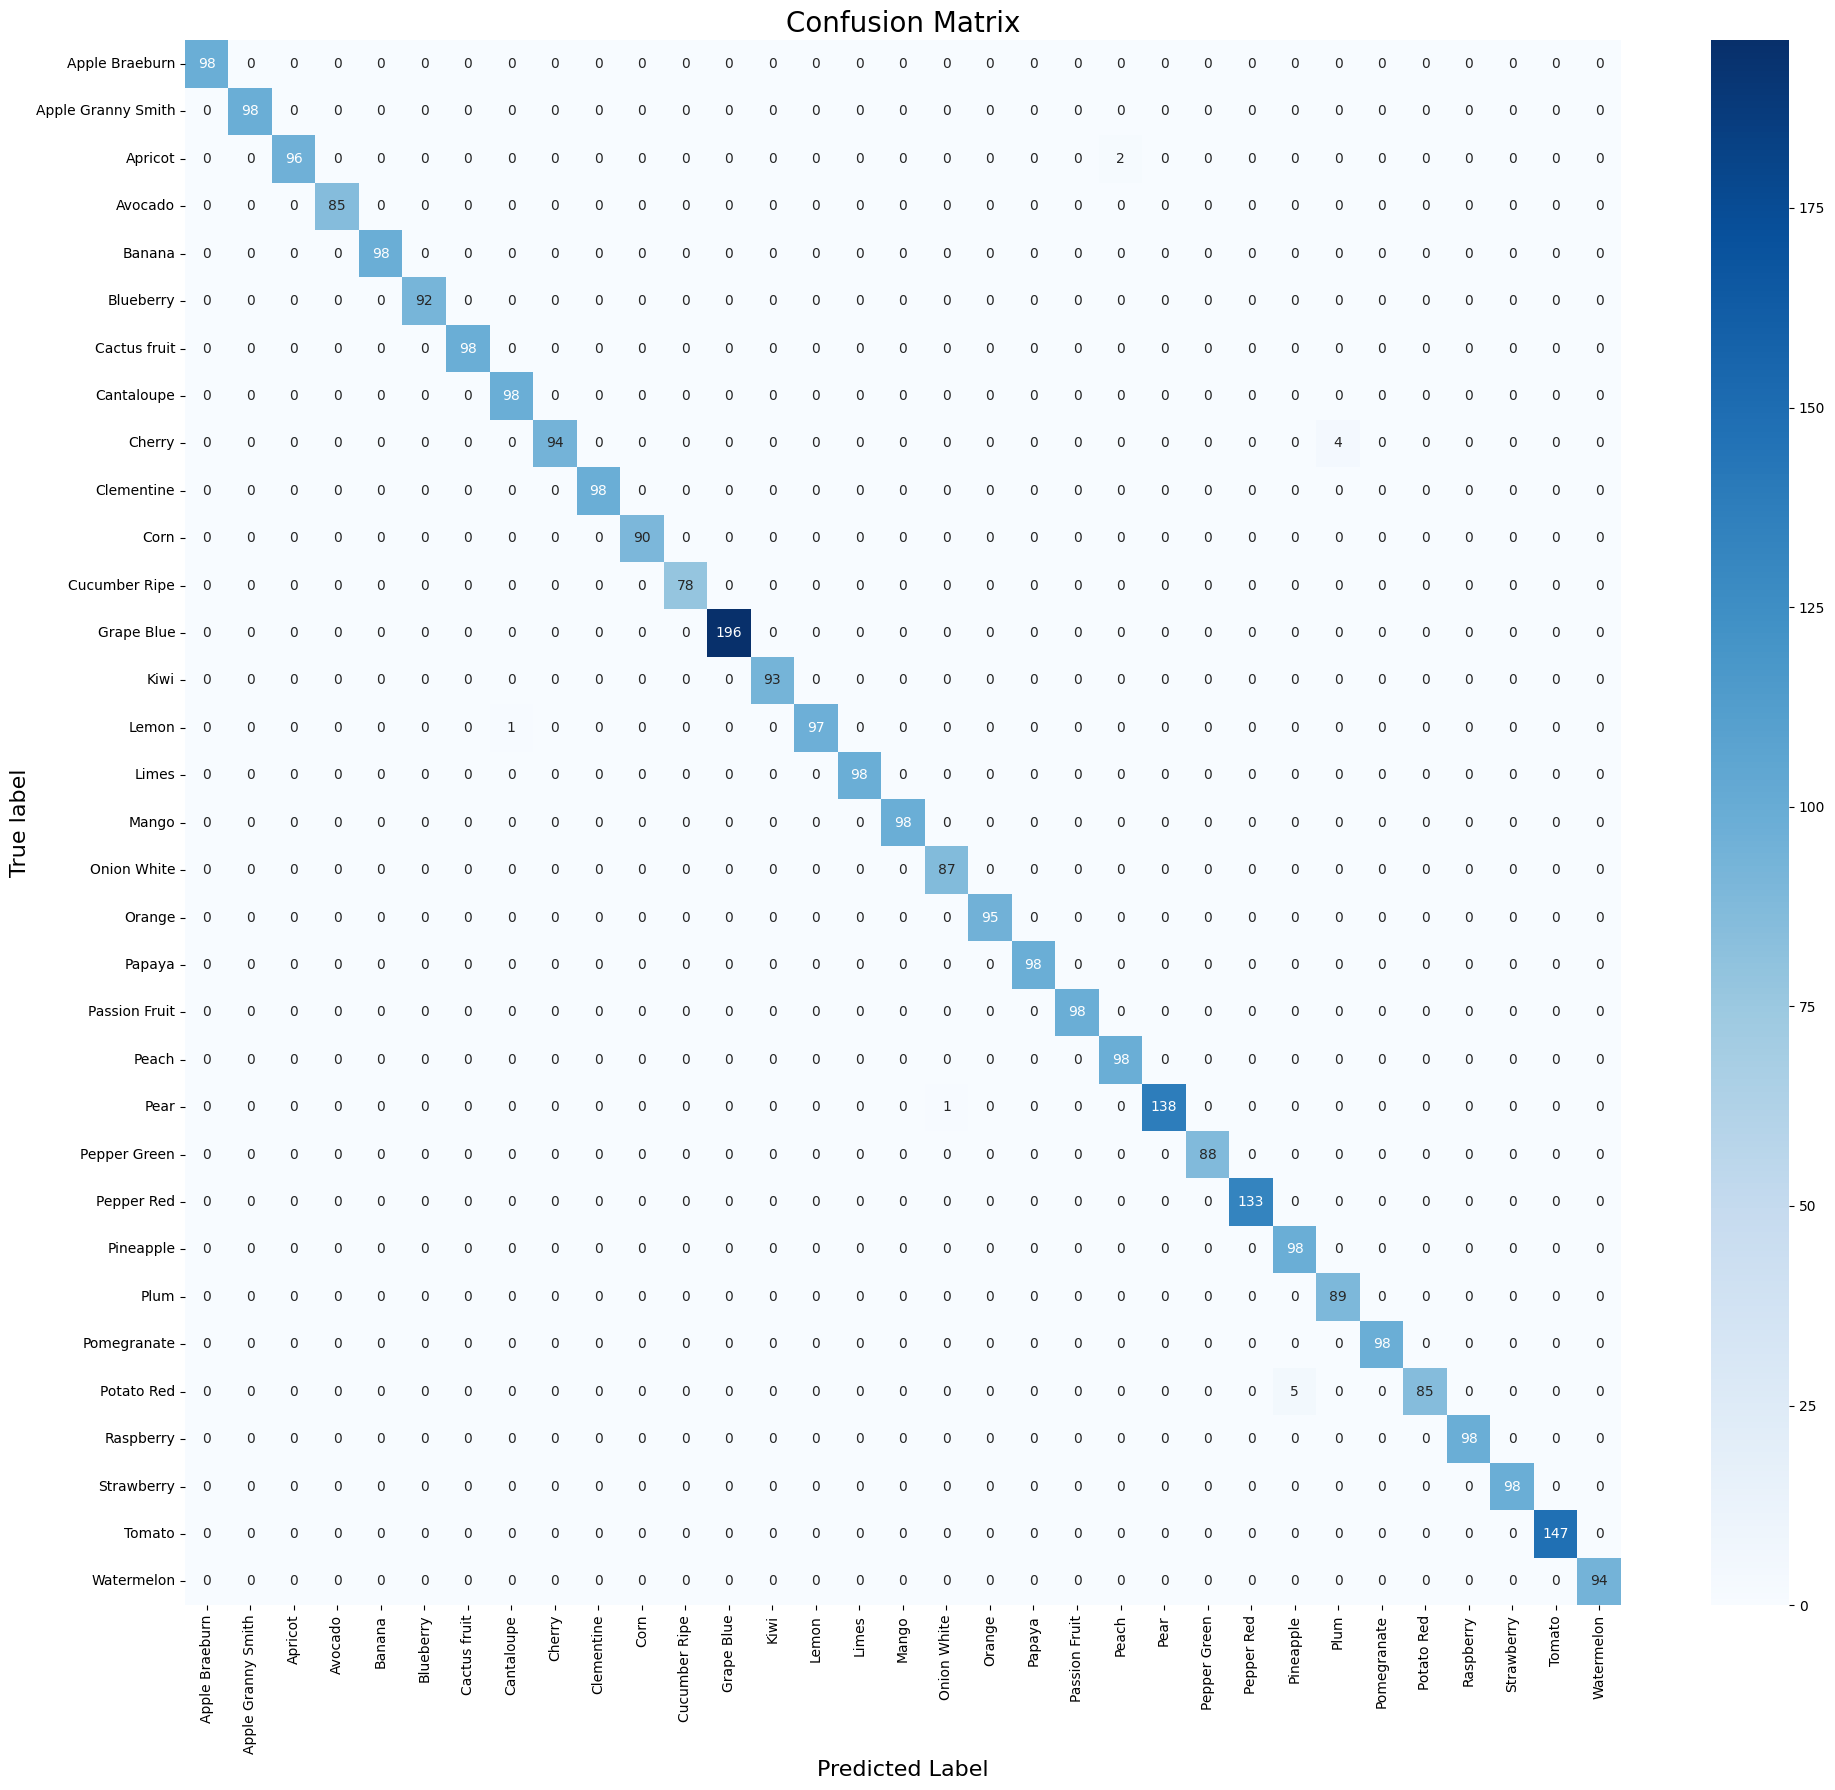

In [ ]:
cm = confusion_matrix(validation_labels[:len(predicted_labels)], predicted_labels)

plt.figure(figsize=(20, 18))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix", fontsize=20)
plt.xlabel("Predicted Label", fontsize=16)
plt.ylabel("True label", fontsize=16)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
model.save("my_fruit_model.keras")
print("Model saved succesfully as 'fruit_model.keras'")

Model saved succesfully as 'fruit_model.keras'


In [ ]:
# -------------------------------
# FORCE CPU (avoid transfer manager errors)
# -------------------------------
os.environ["CUDA_VISIBLE_DEVICES"] = ""
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"

# -------------------------------
# LOAD MODEL
# -------------------------------
model_path = "/content/my_fruit_model.keras"
model = load_model(model_path, compile=False)

# -------------------------------
# CLASS LABELS
# -------------------------------
class_labels = [
    'Apple Braeburn', 'Apple Granny Smith', 'Apricot', 'Avocado', 'Banana',
    'Blueberry', 'Cactus fruit', 'Cantaloupe', 'Cherry', 'Clementine', 'Corn',
    'Cucumber Ripe', 'Grape Blue', 'Kiwi', 'Lemon', 'Limes', 'Mango',
    'Onion White', 'Orange', 'Papaya', 'Passion Fruit', 'Peach', 'Pear',
    'Pepper Green', 'Pepper Red', 'Pineapple', 'Plum', 'Pomegranate',
    'Potato Red', 'Raspberry', 'Strawberry', 'Tomato', 'Watermelon'
]

# -------------------------------
# IMAGE PREPROCESSING
# -------------------------------
def preprocess_image(image_path, target_size=(100, 100)):
    """Load image, resize, normalize and expand dimensions for prediction."""
    img = Image.open(image_path).convert("RGB")
    img = img.resize(target_size)
    img_array = np.array(img).astype("float32") / 255.0
    return np.expand_dims(img_array, axis=0)

# -------------------------------
# PREDICTION FUNCTION
# -------------------------------
def predict_image(img_path):
    """Predict and display image with label and confidence."""
    x = preprocess_image(img_path)
    x = tf.convert_to_tensor(x)

    with tf.device("/CPU:0"):
        preds = model(x, training=False).numpy()

    idx = np.argmax(preds, axis=1)[0]
    label = class_labels[idx]
    conf = preds[0][idx] * 100

    # Display image with predicted label
    plt.imshow(Image.open(img_path))
    plt.axis("off")
    plt.title(f"Predicted: {label} ({conf:.2f}%)", fontsize=14)
    plt.show()

    # Print prediction info
    print(f"📂 File: {os.path.basename(img_path)}")
    print(f"✅ Prediction: {label} ({conf:.2f}%)\n")

# -------------------------------
# TEST IMAGES
# -------------------------------
test_path = "/content/fruit-recognition/test/test"
image_files = sorted([f for f in os.listdir(test_path) if f.lower().endswith(".jpg")])

# -------------------------------
# WIDGETS
# -------------------------------
dropdown = widgets.Dropdown(
    options=image_files,
    description="Choose Image:",
    layout=widgets.Layout(width="60%")
)

count_box = widgets.BoundedIntText(
    value=1,
    min=1,
    max=len(image_files),
    step=1,
    description="How many:",
    layout=widgets.Layout(width="30%")
)

button = widgets.Button(description="Predict ✅", button_style="success")
output = widgets.Output()

def on_submit(b):
    output.clear_output()
    with output:
        start_index = image_files.index(dropdown.value)
        num = min(count_box.value, len(image_files) - start_index)
        selected_files = image_files[start_index:start_index+num]
        for f in selected_files:
            predict_image(os.path.join(test_path, f))

button.on_click(on_submit)

# -------------------------------
# DISPLAY WIDGETS
# -------------------------------
display(widgets.VBox([dropdown, count_box, button, output]))